In [1]:
# General imports
from multiprocessing import Pool  # Multiprocess Runs
import numpy as np
import pandas as pd
import os
import sys
import gc
import time
import warnings
import pickle
import random
import datetime
import shutil

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.backend as K
import tensorflow_probability as tfp

tfkl = tfk.layers
tfd = tfp.distributions

# custom imports

warnings.filterwarnings('ignore')

# Start data preprocessing 

In [2]:
CAL_DTYPES = {"event_name_1": "category", "event_name_2": "category", "event_type_1": "category",
              "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
              "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32'}
PRICE_DTYPES = {"store_id": "category", "item_id": "category",
                "wm_yr_wk": "int16", "sell_price": "float32"}

In [3]:
h = 28
max_lags = 57
tr_last = 1913
fday = datetime.datetime(2016, 4, 25)

In [7]:
def create_dt(is_train=True, nrows=None, first_day=1200):
    prices = pd.read_csv("../data/raw/sell_prices.csv", dtype=PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()

    cal = pd.read_csv("../data/raw/calendar.csv", dtype=CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()

    start_day = max(1 if is_train else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day, tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
    dtype = {numcol: "float32" for numcol in numcols}
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("../data/raw/sales_train_validation.csv",
                     nrows=nrows, usecols=catcols + numcols, dtype=dtype)

    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()

    if not is_train:
        for day in range(tr_last+1, tr_last + 28 + 1):
            dt[f"d_{day}"] = np.nan

    dt = pd.melt(dt,
                 id_vars=catcols,
                 value_vars=[
                     col for col in dt.columns if col.startswith("d_")],
                 var_name="d",
                 value_name="sales")

    dt = dt.merge(cal, on="d", copy=False)
    dt = dt.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], copy=False)

    return dt


def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id", "sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby(
                "id")[lag_col].transform(lambda x: x.rolling(win).mean())

    date_features = {

        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
        #         "ime": "is_month_end",
        #         "ims": "is_month_start",
    }

    #     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(
                dt["date"].dt, date_feat_func).astype("int16")

In [8]:
# tensorflow utils functions
class CustomCallbackLargeDataset(tfk.callbacks.Callback):
    def __init__(self, print_n_batch=1000, print_n_epoch=1):
        super(CustomCallback, self).__init__()
        self.print_n_epoch = print_n_epoch
        self.print_n_batch = print_n_batch
        self.seen = 0

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                              self.params['steps'],
                                              metrics_log))
            self.metric_cache.clear()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.print_n_epochs == 0:
            try:
                print(
                    f"Epoch {epoch} loss : {logs['loss']:.2f}, mse :{logs['root_mean_squared_error']:.2f}")
            except:
                print(f"Epoch {epoch} loss : {logs['loss']:.2f}")

In [9]:
FIRST_DAY = 350  # 350 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !
df = create_dt(is_train=True, first_day=FIRST_DAY)
create_fea(df)

In [10]:
df.dropna(inplace=True)
gc.collect()

20

In [11]:
print(f"Memory usage of the dataframe : {df.memory_usage().sum()/1e9}GB ")

Memory usage of the dataframe : 4.29453959GB 


In [12]:
# get the weights for the training (the older the sample the less it will have impact )
weights = df['d'].str[2:].astype(int)
weights = weights/np.sum(weights)

# weights based on the amplitude of the sales
p_sampling = df['sales']/df['sales'].sum()

In [13]:
cat_feats = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id'] + \
    ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales", "d", "wm_yr_wk", "weekday"]
num_feats = df.columns[~df.columns.isin(useless_cols+cat_feats)].to_list()
train_cols = num_feats+cat_feats

X_train = df[train_cols]
y_train = df["sales"]

np.random.seed(777)
fake_valid_inds = np.random.choice(
    X_train.index.values, 2_000_000, replace=False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

X_test, y_test = X_train.loc[fake_valid_inds], y_train.loc[fake_valid_inds]
X_train, y_train = X_train.loc[train_inds], y_train.loc[train_inds]

X_train[num_feats], X_test[num_feats] = X_train[num_feats].astype(
    np.float32), X_test[num_feats].astype(np.float32)
X_train[cat_feats], X_test[cat_feats] = X_train[cat_feats].astype(
    np.int32), X_test[cat_feats].astype(np.int32)

cardinality = df[cat_feats].max()
weights_train = weights.loc[X_train.index]
p_sampling_train = p_sampling.loc[X_train.index]

In [14]:
# prepare input for tensorflow
# as we have multiple input type the best solution is to feed a dict like object

input_dict = {f"input_{col}": X_train[col] for col in X_train.columns}
input_dict_test = {f"input_{col}": X_test[col] for col in X_train.columns}

del df, X_train, X_test
gc.collect()

92

## Start the tensorflow modeling 

In [15]:
# %load_ext tensorboard
# %tensorboard --logdir=C:\Users\Killian\Documents\python_code\Kaggle\m5-forecasting-accuracy\logs

In [24]:
# TF2 model
# loss for a poisson regression


def poisson(y_true, y_pred):
    '''
    Loss computed as a Poisson regression 
    '''
    return K.mean(K.maximum(.0, y_pred) - y_true * K.log(K.maximum(.0, y_pred) + K.epsilon()), axis=-1)


def tweedie_loss(y_true, y_pred):
    '''
    Tweedie regression, same style as poisson 

    '''
    p = 1.5
    dev = K.pow(y_true, 2-p)/((1-p) * (2-p)) \
        - y_true * K.pow(K.maximum(.0, y_pred) + K.epsilon(), 1-p)/(1-p) \
        + K.pow(K.maximum(.0, y_pred) + K.epsilon(), 2-p)/(2-p)
    return K.mean(dev, axis=-1)


alpha = .5


def weighted_loss(y_true, y_pred):
    '''
    make a comprised loss of poisson and tweedie distribution
    '''
    return (1 - alpha) * poisson(y_true, y_pred) + alpha * tweedie(y_true, y_pred)

# function to generate the MLP


def create_mlp(layers_list=[128, 64, 32, 16],
               emb_dim=30,
               loss_fn='poisson',
               learning_rate=1e-3,
               optimizer=tfk.optimizers.Adam,
               verbose=1):
    '''
    description : 
    generate regression mlp with
    both embedding entries for categorical features and 
    standard inputs for numerical features

    params:
    layers_list : list of layers dimensions 
    emb_dim : maximum embedding size
    output :
    uncompiled keras model  
    '''

    # define our MLP network
    layers = []
    output_num = []
    inputs = []
    output_cat = []
    output_num = []

    # sequencial inputs

    # numerical data part
    if len(num_feats) > 1:
        for num_var in num_feats:
            input_num = tfkl.Input(
                shape=(1,), name='input_{0}'.format(num_var))
            inputs.append(input_num)
            output_num.append(input_num)
        output_num = tfkl.Concatenate(name='concatenate_num')(output_num)
        output_num = tfkl.BatchNormalization()(output_num)

    else:
        input_num = tfkl.Input(
            shape=(1,), name='input_{0}'.format(numeric_features[0]))
        inputs.append(input_num)
        output_num = input_num

    # categorical data input
    for categorical_var in cat_feats:
        # should me nunique() but events are poorly preprocessed
        no_of_unique_cat = cardinality[categorical_var]
        if verbose == 1:
            print(categorical_var, no_of_unique_cat)
        embedding_size = min(np.ceil((no_of_unique_cat)/2), emb_dim)
        embedding_size = int(embedding_size)
        vocab = no_of_unique_cat+1
        # functionnal loop
        input_cat = tfkl.Input(
            shape=(1,), name='input_{0}'.format(categorical_var))
        inputs.append(input_cat)
        embedding = tfkl.Embedding(vocab,
                                   embedding_size,
                                   #embeddings_regularizer = tf.keras.regularizers.l1(1e-8),
                                   name='embedding_{0}'.format(categorical_var))(input_cat)
        embedding = tfkl.Dropout(0.1)(embedding)
        vec = tfkl.Flatten(name='flatten_{0}'.format(
            categorical_var))(embedding)

        output_cat.append(vec)
    output_cat = tfkl.Concatenate(name='concatenate_cat')(output_cat)

    # concatenate numerical input and embedding output
    dense = tfkl.Concatenate(name='concatenate_all')([output_num, output_cat])

    for i in range(len(layers_list)):
        dense = tfkl.Dense(layers_list[i],
                           name='Dense_{0}'.format(str(i)),
                           activation='elu')(dense)
        dense = tfkl.Dropout(.1)(dense)
        dense = tfkl.BatchNormalization()(dense)

    output = tfkl.Dense(1, name='Output', activation='linear')(dense)
    model = tfk.Model(inputs, output)

    opt = optimizer(learning_rate)

    if loss_fn == 'poisson':
        model.compile(loss=poisson, optimizer=opt, metrics=[
                      tf.keras.metrics.RootMeanSquaredError()])
    elif loss_fn == 'tweedie':
        model.compile(loss=tweedie_loss, optimizer=opt, metrics=[
                      tf.keras.metrics.RootMeanSquaredError()])
    else:
        raise ValueError(
            "Loss function should be either Poisson or tweedie for now")

    return model


try:
    del mdl
except:
    pass

mdl = create_mlp(loss_fn='poisson')
mdl.summary()

item_id 3048
dept_id 6
store_id 9
cat_id 2
state_id 2
event_name_1 30
event_name_2 4
event_type_1 4
event_type_2 2
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_item_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_dept_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_store_id (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_cat_id (InputLayer)       [(None, 1)]          0                      

In [25]:
# training of the algorithm 

# checkpointsthe model to reload the best parameters
model_save = tfk.callbacks.ModelCheckpoint('model_checkpoints')

# Early stopping callback
early_stopping = tfk.callbacks.EarlyStopping('val_root_mean_squared_error',
                                             patience=10,
                                             restore_best_weights=True)

# Logging for the tensorboard following
log_dir = "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# # Tensorbard callback
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
#                                                       histogram_freq=1)

history = mdl.fit(input_dict,
                  y_train.values,
                  validation_data=(input_dict_test, y_test.values),
                  batch_size=4096,
                  epochs=25,
                  shuffle=True,
                  # importance of the samples based of the ages
                  sample_weight=weights_train.values,
                  callbacks=[model_save, early_stopping],
                  verbose=1,
                  )


  ...
    to  
  ['...']
Train on 37041269 samples, validate on 2000000 samples
Epoch 1/25
37041269/37041269 [==============================] - 95s 3us/sample - loss: 2.5753e-08 - root_mean_squared_error: 3.5672 - val_loss: -0.0753 - val_root_mean_squared_error: 3.3069
Epoch 2/25
37041269/37041269 [==============================] - 92s 2us/sample - loss: 4.0230e-10 - root_mean_squared_error: 3.1705 - val_loss: -0.1737 - val_root_mean_squared_error: 3.0915
Epoch 3/25
37041269/37041269 [==============================] - 91s 2us/sample - loss: -1.4915e-09 - root_mean_squared_error: 3.0305 - val_loss: -0.3020 - val_root_mean_squared_error: 2.9337
Epoch 4/25
37041269/37041269 [==============================] - 89s 2us/sample - loss: -4.2490e-09 - root_mean_squared_error: 2.9104 - val_loss: -0.3339 - val_root_mean_squared_error: 2.8787
Epoch 5/25
37041269/37041269 [==============================] - 89s 2us/sample - loss: -4.9058e-09 - root_mean_squared_error: 2.8731 - val_loss: -0.3589 - val

37041269/37041269 [==============================] - 86s 2us/sample - loss: -6.5522e-09 - root_mean_squared_error: 2.7007 - val_loss: -0.3994 - val_root_mean_squared_error: 2.6417
Epoch 24/25
37041269/37041269 [==============================] - 85s 2us/sample - loss: -6.3540e-09 - root_mean_squared_error: 2.7037 - val_loss: -0.3980 - val_root_mean_squared_error: 2.6474
Epoch 25/25
37041269/37041269 [==============================] - 86s 2us/sample - loss: -6.5788e-09 - root_mean_squared_error: 2.6973 - val_loss: -0.4003 - val_root_mean_squared_error: 2.6355


In [21]:
mdl.save('keras_tweedie.h5')

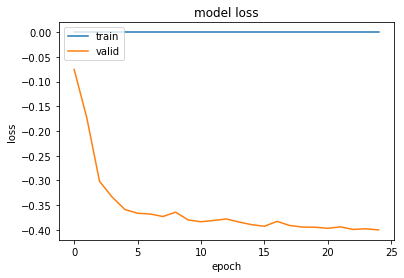

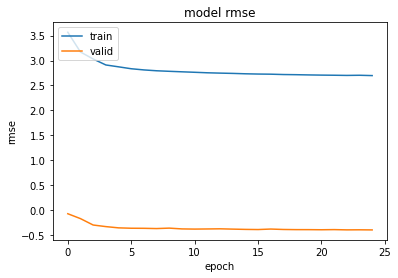

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.savefig('poisson.png')

In [ ]:
from datetime import timedelta
alphas = [1.035, 1.03, 1.025]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1, 29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(icount, day)
        tst = te[(te.date >= day - timedelta(days=max_lags))
                 & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day, train_cols]
        input_dict_predict = {f"input_{col}": tst[col] for col in tst.columns}
        pred = mdl.predict(input_dict_predict, batch_size=10000)
        te.loc[te.date == day, "sales"] = alpha*pred
        print(pred)

    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h),
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")[
        "id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F"]).unstack()[
        "sales"][cols].reset_index()
    te_sub.fillna(0., inplace=True)
    te_sub.sort_values("id", inplace=True)
    te_sub.reset_index(drop=True, inplace=True)
    te_sub.to_csv(f"submission_{icount}.csv", index=False)
    if icount == 0:
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv", index=False)

## Make optimization for the NN 

In [ ]:
# imports we know we'll need only for BGS 
import skopt
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import CheckpointSaver, VerboseCallback

In [ ]:
# start to generate the search space for the gaussian process

dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=7, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=32, high=2048, name='num_dense_nodes')

dim_batch_size = Integer(low=2048, high=10000, name='batch_size')
dim_emb_dim = Integer(low=10, high=50, name='emb_dim')

dim_loss_fn = Categorical(categories=['poisson', 'tweedie'], name='loss_fn')

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_emb_dim,
              dim_batch_size,
              dim_loss_fn,
              ]

In [ ]:
# Make the optimization of HP functions using skopt
@use_named_args(dimensions=dimensions)
def fitness(learning_rate,
            num_dense_layers,
            num_dense_nodes,
            batch_size,
            emb_dim,
            loss_fn,
            ):

    # generate a list of the MLP architecture
    # Enforce a funnel like structure
    list_layer = [num_dense_nodes//(2**x) for x in range(num_dense_layers)]

    model = create_mlp(layers_list=list_layer,
                       emb_dim=emb_dim,
                       loss_fn='poisson',
                       learning_rate=learning_rate,
                       optimizer=tfk.optimizers.Adam
                       )

    print(
        f'Generated a model with {model.count_params()} trainable parameters')

    # checkpointsthe model to reload the best parameters

    try:
        shutil.rmtree('./model_checkpoints')
        print('Old checkpoint remove')
    except:
        pass

    model_save = tfk.callbacks.ModelCheckpoint('model_checkpoints')

    # Early stopping callback
    early_stopping = tfk.callbacks.EarlyStopping('val_root_mean_squared_error',
                                                 patience=10,
                                                 restore_best_weights=True)
    history = model.fit(input_dict,
                        y_train.values,
                        validation_data=(input_dict_test, y_test.values),
                        batch_size=batch_size,
                        epochs=100,
                        shuffle=True,
                        # importance of the samples based of the ages
                        sample_weight=weights_train.values,
                        callbacks=[model_save, early_stopping],
                        verbose=1,
                        )
    # return the validation accuracy for the last epoch.
    rmse = history.history['val_root_mean_squared_error'][-1]

    # Print the classification accuracy.
    print()
    print("RMSE: {:.2}".format(rmse))
    print()

    global best_rmse
    if rmse < best_rmse:
        model.save('keras_best_model.h5')
        best_rmse = rmse
    print("Best RMSE: {:.2}".format(rmse))

    # Delete the Keras model with these hyper-parameters from memory(not sure if needed in tf2)
    del model, early_stopping, model_save
    # Clear the Keras session
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()
    return rmse

In [ ]:
# make the optimization interuptible
import warnings
warnings.filterwarnings('ignore')

checkpoint_callback = skopt.callbacks.CheckpointSaver("./result.pkl")

best_rmse = 1000
gp_result = gp_minimize(func=fitness,
                        dimensions=dimensions,
                        n_calls=20,
                        n_jobs=1,
                        verbose=True,
                        callback=[checkpoint_callback],
                        )

In [ ]:
print(gp_result.best_estimator_)
print(gp_result.best_params_)

In [ ]:
from skopt.plots import plot_objective
_ = plot_convergence(gp_result)
_ = plot_objective(gp_result)

## Output the forecast results 

# TFP 

In [ ]:
tfd = tfp.distributions

# prior distribution on the weights 
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

# layer posterior distribution with mean field approximation  
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + 0.02*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

# probabilistic  loss functions
def neg_log_likelihood_continuous(y_true, y_pred):
    '''
    negative log likelyhood for stricly positive distributions 
    
    '''
    return -y_pred.prob(y_true+1e-6)


def neg_log_likelihood_discrete(y_true, y_pred):
    '''
    negloglik when we don't care 
    '''
    return -y_pred.log_prob(y_true)

# custom metrics


def rmse(y_true, y_pred):
    '''
    compact implemtation of the rmse 
    '''
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred-y_true)))


# to much scaling: high variance, no enough -> converge to the likelyhood
kl_weight = batch_size/training_size 
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                          kl_weight)  # KL over the batch of 2048 (should normalize by the number of mini batch)


def create_mlp(layers_list=[512, 512, 512, 64],
               type_output='poisson'):
    '''
    description : 
    generate regression mlp with
    both embedding entries for categorical features and 
    standard inputs for numerical features

    params:
    layers_list : list of layers dimensions 
    output :
    compiled keras model  
    '''

    # define our MLP network
    layers = []
    output_num = []
    inputs = []
    output_cat = []
    output_num = []

    # numerical data part
    if len(num_feats) > 1:
        for num_var in num_feats:
            input_num = tfkl.Input(
                shape=(1,), name='input_{0}'.format(num_var))
            inputs.append(input_num)
            output_num.append(input_num)
        output_num = tfkl.Concatenate(name='concatenate_num')(output_num)
        #output_num = tfkl.BatchNormalization()(output_num)

    else:
        input_num = tfkl.Input(
            shape=(1,), name='input_{0}'.format(numeric_features[0]))
        inputs.append(input_num)
        output_num = input_num

    # create an embedding for every categorical feature
    for categorical_var in cat_feats:
        # should me nunique() but events are poorly preprocessed
        no_of_unique_cat = cardinality[categorical_var]
        print(categorical_var, no_of_unique_cat)
        embedding_size = min(np.ceil((no_of_unique_cat)/2), 30)
        embedding_size = int(embedding_size)
        vocab = no_of_unique_cat+1
        # functionnal loop
        input_cat = tfkl.Input(
            shape=(1,), name='input_{0}'.format(categorical_var))
        inputs.append(input_cat)
        embedding = tfkl.Embedding(vocab,
                                   embedding_size,
                                   #embeddings_regularizer = tf.keras.regularizers.l1(1e-8),
                                   name='embedding_{0}'.format(categorical_var))(input_cat)
        embedding = tfkl.Dropout(0.1)(embedding)
        vec = tfkl.Flatten(name='flatten_{0}'.format(
            categorical_var))(embedding)
        output_cat.append(vec)
    output_cat = tfkl.Concatenate(name='concatenate_cat')(output_cat)

    # concatenate numerical input and embedding output
    dense = tfkl.Concatenate(name='concatenate_all')([output_num, output_cat])

    for i in range(len(layers_list)):
        dense = tfkl.Dense(layers_list[i],
                           name='Dense_{0}'.format(str(i)),
                           activation='elu')(dense)
        dense = tfkl.Dropout(.1)(dense)
        dense = tfkl.BatchNormalization()(dense)

    # lognormal
    if type_output == 'gaussian':
        dense2 = tfk.layers.Dense(2,
                                  activation='softplus',
                                  name='Output'
                                  )(dense)

        output = tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(t[..., 0], scale=t[..., 1:]))(dense2)

    # Poisson
    elif type_output == 'poisson':
        dense2 = tfk.layers.Dense(1,
                                  name='Output')(dense)
        output = tfp.layers.DistributionLambda(
            lambda t: tfd.Poisson(rate=tf.math.softplus(t[..., 0])))(dense2)

    # Gamma
    elif type_output == 'gamma':
        dense2 = tfk.layers.Dense(2,
                                  name='Output',
                                  activation='softplus',
                                  )(dense)

        output = tfp.layers.DistributionLambda(
            lambda t: tfd.Gamma(concentration=.01*t[..., 0],
                                rate=.01*t[..., 1]))(dense2)
    else:
        output = tfk.Dense(1)

    model = tfk.Model(inputs, output)
    opt = tfk.optimizers.Nadam(learning_rate=1e-2)

    model.compile(loss=neg_log_likelihood_continuous,
                  optimizer=opt,
                  metrics=[rmse])
    return model


try:
    del mdl_tfp
    print('model deleted ')
except:
    pass

mdl_tfp = create_mlp(type_output='poisson')

In [ ]:
gc.collect()
history = mdl_tfp.fit(input_dict,
                      y_train.values,
                      validation_data=(input_dict_test, y_test.values),
                      batch_size=4096,
                      epochs=2,
                      shuffle=True,
                      verbose=1,
                      )

# Make  a custom batch generator 
based on https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
class DataGenerator(tfk.utils.Sequence):
    'Generates data for tfk'

    def __init__(self, list_IDs, labels, batch_size=32, dim=(32, 32, 32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # X : (n_samples, *dim, n_channels)
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i, ] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [ ]:
# # make a custom random sampled training loop
# # need to call the model with training = True for the custom training to handle dropout and BN

# def random_batch(input_X,y,batch_size=128,sample_weights=None):
#     # take a sample batch based on the weighting
#     idx = np.random.choice(range(len(input_X)),sample_weights,batch_size)
#     return input_X[idx],y[idx]


# model = create_mlp()

# # initialoze parameters
# n_epochs = 5
# batch_size = 2048
# n_steps = 50
# opt = tfk.optimizers.Adam(learning_rate=1e-3)
# loss_fn = poisson
# mean_loss = tfk.metrics.Mean()

In [ ]:
# create a fully bayesian network

def create_mlp_full_bayes(layers_list=[512, 256, 128, 64],
                          type_output='poisson'):
    '''
    description : 
    generate regression mlp with
    both embedding entries for categorical features and 
    standard inputs for numerical features

    params:
    layers_list : list of layers dimensions 
    output :
    compiled keras model  
    '''

    # define our MLP network
    layers = []
    output_num = []
    inputs = []
    output_cat = []
    output_num = []

    # numerical data part
    if len(num_feats) > 1:
        for num_var in num_feats:
            input_num = tfkl.Input(
                shape=(1,), name='input_{0}'.format(num_var))
            inputs.append(input_num)
            output_num.append(input_num)
        output_num = tfkl.Concatenate(name='concatenate_num')(output_num)
        #output_num = tfkl.BatchNormalization()(output_num)

    else:
        input_num = tfkl.Input(
            shape=(1,), name='input_{0}'.format(numeric_features[0]))
        inputs.append(input_num)
        output_num = input_num

    # create an embedding for every categorical feature
    for categorical_var in cat_feats:
        # should me nunique() but events are poorly preprocessed
        no_of_unique_cat = cardinality[categorical_var]
        print(categorical_var, no_of_unique_cat)
        embedding_size = 10  # min(np.ceil((no_of_unique_cat)/2), 10)
        embedding_size = int(embedding_size)
        vocab = no_of_unique_cat+1
        # functionnal loop
        input_cat = tfkl.Input(
            shape=(1,), name='input_{0}'.format(categorical_var))
        inputs.append(input_cat)
        embedding = tfkl.Embedding(
            vocab, embedding_size, name='embedding_{0}'.format(
                categorical_var),
            embeddings_initializer='random_uniform'
        )(input_cat)
        vec = tfkl.Flatten(name='flatten_{0}'.format(
            categorical_var))(embedding)

        output_cat.append(vec)
    output_cat = tfkl.Concatenate(name='concatenate_cat')(output_cat)

    # concatenate numerical input and embedding output
    dense = tfkl.Concatenate(name='concatenate_all')([output_num, output_cat])

    for i in range(len(layers_list)):
        dense = tfp.layers.DenseVariational(layers_list[i],
                                            activation='elu',
                                            name='Dense_{0}'.format(str(i)),
                                            make_posterior_fn=posterior_mean_field,
                                            make_prior_fn=prior_trainable,
                                            kl_weight=1/2048,
                                            )(dense)
        dense = tfp.bijectors.BatchNormalization()(dense)

    if type_output == 'gaussian':
        dense2 = tfp.layers.DenseVariational(2,
                                             #activation = 'softplus',
                                             make_posterior_fn=posterior_mean_field,
                                             make_prior_fn=prior_trainable,
                                             kl_weight=1/2048,
                                             )(dense)
        output = tfp.layers.DistributionLambda(
            lambda t: tfd.LogNormal(tf.math.softplus(0.05 * t[..., 0]),
                                    scale=1e-6 + tf.math.softplus(0.05 * t[..., 1:])))(dense2)
    # Poisson
    elif type_output == 'poisson':
        dense2 = tfp.layers.DenseVariational(2,
                                             posterior_mean_field,
                                             prior_trainable,
                                             # kl_weight=1/100000
                                             )(dense)
        dense2 = tfp.layers.DenseFlipout(2)(dense)
        output = tfp.layers.DistributionLambda(
            lambda t: tfd.Poisson(rate=tf.math.softplus(t[..., 0])))(dense2)

    # Gamma
    elif type_output == 'gamma':
        #         dense2 = tfp.layers.DenseFlipout(2,
        #                                   name='Output',
        #                                   activation = 'softplus',
        # #                                   kernel_prior =prior_trainable,
        # #                                  kernel_divergence_fn=kl_divergence_function,
        #                                  )(dense)
        dense2 = tfp.layers.DenseVariational(2,
                                             name='Output',
                                             activation='linear',
                                             make_posterior_fn=posterior_mean_field,
                                             kl_weight=1/2048,

                                             make_prior_fn=prior_trainable,
                                             )(dense)
        output = tfp.layers.DistributionLambda(
            lambda t: tfd.Gamma(concentration=t[..., 0],
                                rate=t[..., 1]))(dense2)

    else:
        output = tfk.Dense(1, kernel_divergence_fn=kl_divergence_function,
                           name='Output')(dense)

    model = tfk.Model(inputs, output)
    opt = tfk.optimizers.Adam(learning_rate=1e-3)
    # kl divergence is direclty added to the loss function
    model.compile(loss=neg_log_likelihood_continuous, optimizer=opt,
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model